In [0]:
#upload the credentials of the kaggle account
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"essan769","key":"00956246db1814626c11fd08f4c8773b"}'}

In [0]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#import the dataset we want to use for our project
#!kaggle competitions download -c house-prices-advanced-regression-techniques
!kaggle competitions download -c digit-recognizer

  0% 0.00/9.16M [00:00<?, ?B/s]
100% 9.16M/9.16M [00:00<00:00, 84.7MB/s]
  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 55.6MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 76.4MB/s]


In [0]:
from zipfile import ZipFile
file_name = "test.csv.zip"

with ZipFile (file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
from zipfile import ZipFile
file_name = "train.csv.zip"

with ZipFile (file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
#lets see the imported files from kaggle competetion
!ls

kaggle.json  sample_submission.csv  test.csv.zip  train.csv.zip
sample_data  test.csv		    train.csv


In [0]:
#!pip install tqdm notebook
#!pip install tqdm
!pip install tqdm -U

In [0]:
import pandas as pd

import torch as th
import torch.nn.functional as F

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

#from tqdm import trange
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

device = th.device('cpu')

In [0]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
print('Train shape:', df_train.shape)
print('Test shape:', df_test.shape)

Train shape: (42000, 785)
Test shape: (28000, 784)


In [0]:
df_train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [0]:
#Splitting data into features and labels
#x = features
#y = labels

x = df_train[df_train.columns[1:]].values
y = df_train['label'].values

x_to_submit = df_test[df_train.columns[1:]].values

**Reshaping features to transform it to a 28x28 image**

In [0]:
x = np.reshape(x, (x.shape[0], 28, 28))
x_to_submit = np.reshape(x_to_submit, (x_to_submit.shape[0], 28, 28))

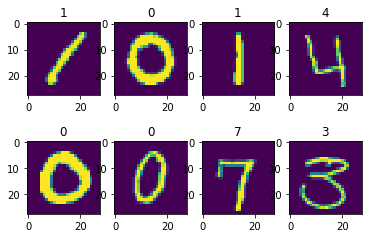

In [0]:
for i in range(8):
    #plt.subplot(5, 4, i+1) when range 20
    plt.subplot(2, 4, i+1)
    plt.imshow(x[i])
    plt.title(y[i])

**Splitting data for training, testing and validation**

In [0]:
x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size = .15, 
                                                            stratify=y, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size = .25, 
                                                stratify=y_test_val, random_state=42)

print('X train shape:', x_train.shape)
print('Y train shape:', y_train.shape)
print()
print('X test shape:', x_test.shape)
print('Y test shape:', y_test.shape)
print()
print('X validation shape:', x_val.shape)
print('Y validation shape:', y_val.shape)

X train shape: (35700, 28, 28)
Y train shape: (35700,)

X test shape: (4725, 28, 28)
Y test shape: (4725,)

X validation shape: (1575, 28, 28)
Y validation shape: (1575,)


**Transforming data to tensor**

In [0]:
def img2tensor(arr, device):
    arr_expand = np.expand_dims(arr, 3)
    arr_transpose = np.transpose(arr_expand, (0, 3, 1, 2))
    tensor = th.from_numpy(arr_transpose).to(device)
    
    return tensor.float()

x_train = img2tensor(x_train, device)
x_test = img2tensor(x_test, device)
x_val = img2tensor(x_val, device)

x_to_submit = img2tensor(x_to_submit, device)

y_train = th.from_numpy(y_train).to(device)
y_test = th.from_numpy(y_test).to(device)
y_val = th.from_numpy(y_val).to(device)

**Creating a DataLoader**

In [0]:
dataset = th.utils.data.TensorDataset(x_train, y_train)

data_loader = th.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)


**Creating our Convolutional neural network**

In [0]:
class CNN(th.nn.Module):
    
    def __init__(self, hidden_size, droupout_p, output_size):
        super(CNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.droupout_p = droupout_p
        self.output_size = output_size
        
        self.norm = th.nn.BatchNorm2d(1)
        
        self.conv1 = th.nn.Conv2d(1, 16, (3, 3))
        self.conv2 = th.nn.Conv2d(16, 32, (4, 4))
        
        self.dropout = th.nn.Dropout(self.droupout_p)
        
        self.fc1 = th.nn.Linear(32*5*5, self.hidden_size)
        self.fc2 = th.nn.Linear(self.hidden_size, self.output_size)
        
        
    def forward(self, x):
        out = self.norm(x)
        
        out = F.relu(self.conv1(out))
        out = F.max_pool2d(out, (2, 2))
        
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, (2, 2))
        
        out = out.view(-1, 32*5*5)
        
        out = F.tanh(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, y_pred = th.max(out, 1)
    
        return y_pred

In [0]:
def decrease_lr(opt, epoch, init_lr):
    lr =  init_lr * (0.1 ** (epoch // 30))
    for param_group in opt.param_groups:
        param_group['lr'] = lr

In [0]:
lr = 0.001
epochs = 90

net = CNN(hidden_size=32, droupout_p=.3, output_size=10).to(device)

opt = th.optim.Adam(net.parameters(), lr)
criterion = th.nn.CrossEntropyLoss()

**Training our net**

In [0]:
!pip install tqdm


In [0]:
losses = []
test_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    print('Epoch:', epoch+1)
    
    decrease_lr(opt, epoch, lr)
    
    net.train()
    batch_losses = []
    for feats, labels in tqdm(data_loader):      
        output = net(feats)
        
        loss = criterion(output, labels)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        batch_losses.append(loss.item())
    
    net.eval()
    
    loss_mean = np.array(batch_losses).mean()
    test_acc = accuracy_score(y_test, net.predict(x_test).data.numpy())
    val_acc = accuracy_score(y_val, net.predict(x_val).data.numpy())
    
    losses.append(loss_mean)
    test_accuracies.append(test_acc)
    val_accuracies.append(val_acc)
    
    print('Loss:', loss_mean)
    print('Test acc:', test_acc)
    print('Validation acc:', val_acc)

Epoch: 1


NameError: ignored